# Naive Bayes — PyTorch (GPU-Accelerated)

Two-part pipeline implementing both Naive Bayes variants using PyTorch tensors on GPU.

**Part 1: GaussianNB** (Breast Cancer — binary classification baseline)
- 455 train / 114 test samples, 30 continuous features, 2 classes
- Gaussian likelihood computed on GPU, log-sum-exp via `torch.logsumexp()`

**Part 2: MultinomialNB** (20 Newsgroups — text classification main event)
- 11,314 train / 7,532 test documents, 10,000 TF-IDF features, 20 categories
- The big matmul `X @ feature_log_prob.T` runs on GPU — (7532, 10000) × (10000, 20)

**Showcase**: CPU vs GPU inference speed — benchmarking the matmul that dominates MultinomialNB prediction to show where GPU acceleration pays off.

In [ ]:
# Step 1: Imports and setup
import sys
import os
import time
import numpy as np
import torch

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance, track_inference, get_model_size
from utils.metrics import evaluate_classifier, print_metrics
from utils.visualization import (plot_calibration_curve, plot_confusion_matrix,
                                  plot_confusion_matrix_multiclass, plot_per_class_f1)
from utils.results import save_results, add_result, print_comparison

# Configuration
RANDOM_STATE = 113
ALPHA = 1.0            # Laplace smoothing for MultinomialNB
VAR_SMOOTHING = 1e-9   # Variance floor for GaussianNB
FRAMEWORK = 'PyTorch'

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Load both datasets (numpy arrays)
X_train_g, X_test_g, y_train_g, y_test_g, meta_g = load_processed_data('naive_bayes_gaussian')
X_train_t, X_test_t, y_train_t, y_test_t, meta_t = load_processed_data('naive_bayes_text')

# Convert features to GPU tensors
# GaussianNB: float64 to match numpy precision (tiny dataset, no cost)
X_train_g_t = torch.tensor(X_train_g, dtype=torch.float64, device=device)
X_test_g_t = torch.tensor(X_test_g, dtype=torch.float64, device=device)
# MultinomialNB: float32 for GPU speed (large dataset)
X_train_t_t = torch.tensor(X_train_t, dtype=torch.float32, device=device)
X_test_t_t = torch.tensor(X_test_t, dtype=torch.float32, device=device)

# Labels to GPU tensors (for boolean masking in training)
y_train_g_t = torch.tensor(y_train_g, dtype=torch.long, device=device)
y_train_t_t = torch.tensor(y_train_t, dtype=torch.long, device=device)

print(f"\n{'=' * 60}")
print(f"NAIVE BAYES — {FRAMEWORK}")
print(f"{'=' * 60}")
print(f"\nPart 1: Breast Cancer (GaussianNB)")
print(f"  Training: {X_train_g_t.shape[0]} samples, {X_train_g_t.shape[1]} features")
print(f"  Test:     {X_test_g_t.shape[0]} samples")
print(f"  Classes:  {meta_g['n_classes']} ({meta_g['class_names']})")
print(f"\nPart 2: 20 Newsgroups (MultinomialNB)")
print(f"  Training: {X_train_t_t.shape[0]:,} samples, {X_train_t_t.shape[1]:,} features")
print(f"  Test:     {X_test_t_t.shape[0]:,} samples")
print(f"  Classes:  {meta_t['n_classes']} categories")

Device: cuda
GPU: NVIDIA GeForce RTX 4090
VRAM: 25.8 GB

NAIVE BAYES — PyTorch

Part 1: Breast Cancer (GaussianNB)
  Training: 455 samples, 30 features
  Test:     114 samples
  Classes:  2 (['malignant', 'benign'])

Part 2: 20 Newsgroups (MultinomialNB)
  Training: 11,314 samples, 10,000 features
  Test:     7,532 samples
  Classes:  20 categories



METRICS — GaussianNB — Breast Cancer
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9385       0.8947
precision                       0.9509       0.9054
recall                          0.9509       0.9306
f1                              0.9509       0.9178
auc                             0.9592       0.9363
log_loss                        0.7158       1.0123
brier_score                     0.0608       0.0983
ece                             0.3703       0.3590


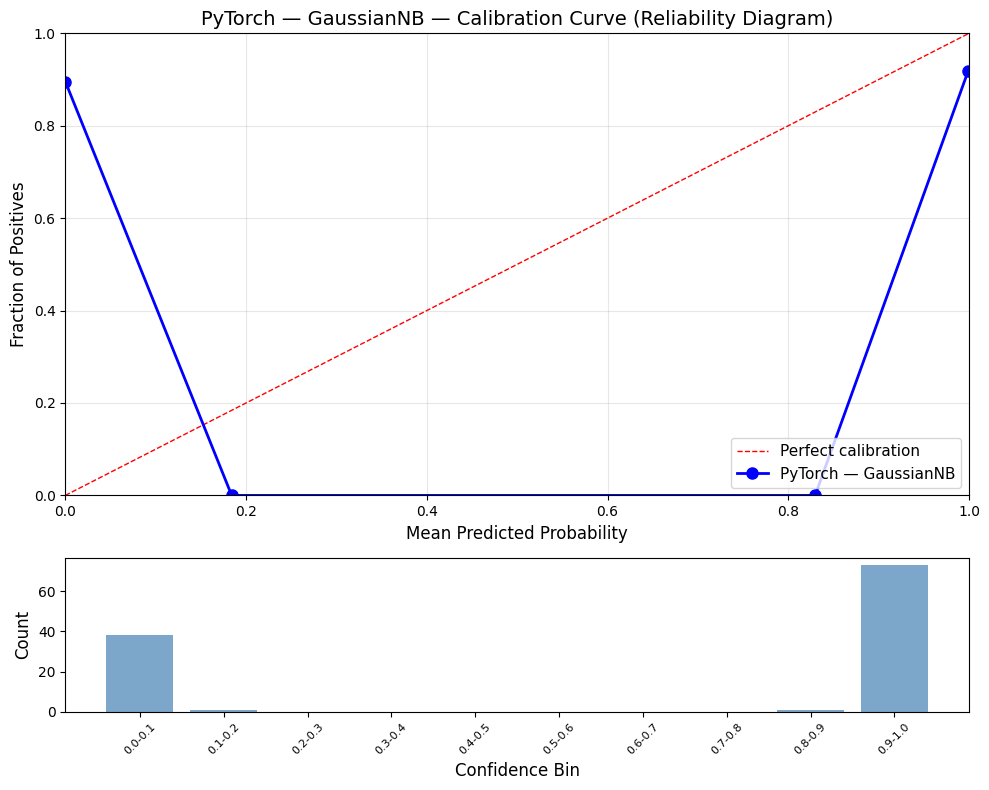

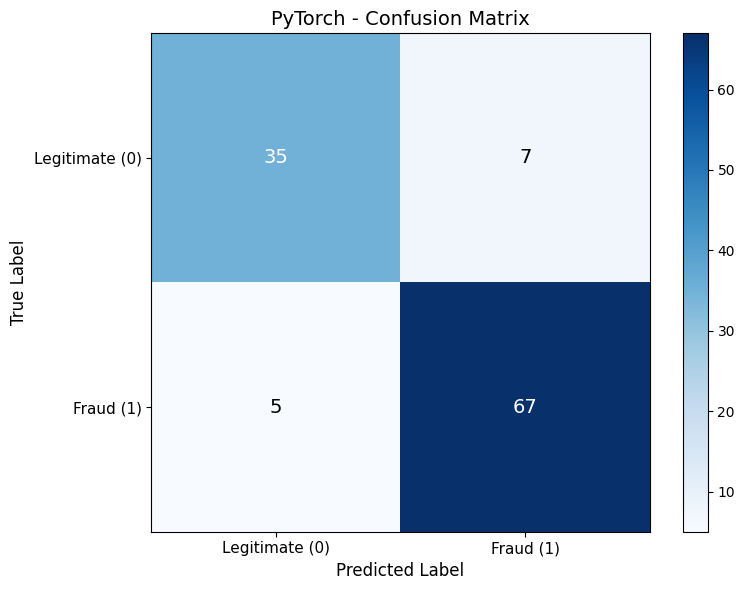


GaussianNB baseline complete.
Key takeaway: 89.5% accuracy, ECE=0.3590


In [3]:
# Step 2: GaussianNB — train, predict, evaluate (Breast Cancer baseline)
def gaussian_nb_train_gpu(X, y):
    """
    Train GaussianNB using PyTorch tensors on GPU.

    Same math as No-Framework but with torch operations:
    per-class means, variances (+ smoothing), and log priors.

    Args:
        X: Training features (n_samples, n_features) GPU tensor.
        y: Training labels (n_samples,) GPU tensor (long).

    Returns:
        dict: Model parameters as GPU tensors.
    """
    classes = torch.unique(y)
    n_classes = len(classes)
    n_samples, n_features = X.shape

    class_means = torch.zeros(n_classes, n_features, device=X.device, dtype=X.dtype)
    class_vars = torch.zeros(n_classes, n_features, device=X.device, dtype=X.dtype)
    class_log_prior = torch.zeros(n_classes, device=X.device, dtype=X.dtype)

    for k, cls in enumerate(classes):
        X_k = X[y == cls] # boolean masking on GPU
        class_means[k] = X_k.mean(dim=0)
        class_vars[k] = X_k.var(dim=0, unbiased=False) + VAR_SMOOTHING  # population var
        class_log_prior[k] = torch.log(torch.tensor(len(X_k) / n_samples, device=X.device, dtype=X.dtype))

    return {
        'classes': classes,
        'class_means': class_means,
        'class_vars': class_vars,
        'class_log_prior': class_log_prior
    }


def gaussian_nb_predict_gpu(model, X):
    """
    Predict with GaussianNB on GPU.

    Gaussian log-likelihood per feature, summed across features.
    Uses torch.logsumexp() for numerically stable softmax (built-in!).

    Args:
        model: Dict from gaussian_nb_train_gpu().
        X: Features (n_samples, n_features) GPU tensor.

    Returns:
        y_pred: Predicted labels (n_samples,) GPU tensor.
        y_proba: Class probabilities (n_samples, n_classes) GPU tensor.
    """
    classes = model['classes']
    means = model['class_means']
    variances = model['class_vars']
    log_prior = model['class_log_prior']

    n_samples = X.shape[0]
    n_classes = len(classes)
    log_posteriors = torch.zeros(n_samples, n_classes, device=X.device, dtype=X.dtype)

    for k in range(n_classes):
        # Gaussian log-likelihood: -0.5 * (log(2*pi*var) + (x - mean)^2 / var)
        log_lik = -0.5 * (
            torch.log(2 * torch.pi * variances[k])
            + (X - means[k]) ** 2 / variances[k]
        )
        log_posteriors[:, k] = log_prior[k] + log_lik.sum(dim=1)

    y_pred = classes[torch.argmax(log_posteriors, dim=1)]

    # torch.logsumexp — PyTorch's built-in log-sum-exp (no manual implementation needed)
    log_norm = torch.logsumexp(log_posteriors, dim=1)
    y_proba = torch.exp(log_posteriors - log_norm.unsqueeze(1))

    return y_pred, y_proba


# Train + evaluate
gnb_model = gaussian_nb_train_gpu(X_train_g_t, y_train_g_t)

train_pred_g, train_proba_g = gaussian_nb_predict_gpu(gnb_model, X_train_g_t)
test_pred_g, test_proba_g = gaussian_nb_predict_gpu(gnb_model, X_test_g_t)

# Convert to numpy for evaluation utils
train_metrics_g = evaluate_classifier(
    y_train_g, train_pred_g.cpu().numpy(), train_proba_g[:, 1].cpu().numpy())
test_metrics_g = evaluate_classifier(
    y_test_g, test_pred_g.cpu().numpy(), test_proba_g[:, 1].cpu().numpy())
print_metrics(train_metrics_g, test_metrics_g, title='GaussianNB — Breast Cancer')

# Visualizations
plot_calibration_curve(y_test_g, test_proba_g[:, 1].cpu().numpy(),
                       f'{FRAMEWORK} — GaussianNB',
                       save_path='results/gaussian_calibration.png')

plot_confusion_matrix(y_test_g, test_pred_g.cpu().numpy(), FRAMEWORK,
                      save_path='results/gaussian_confusion_matrix.png')

print(f"\nGaussianNB baseline complete.")
print(f"Key takeaway: {test_metrics_g['accuracy']:.1%} accuracy, "
      f"ECE={test_metrics_g['ece']:.4f}")


## Part 2: MultinomialNB — 20 Newsgroups Text Classification

MultinomialNB models each class as a multinomial distribution over vocabulary terms. Prediction is dominated by a single matrix multiply: `X @ feature_log_prob.T` — shape (7532, 10000) × (10000, 20). This is where GPU acceleration shines.

**Key PyTorch details:**
- Feature log-probs and class priors stored as GPU tensors (float32 — sufficient for text classification)
- `torch.logsumexp()` replaces manual log-sum-exp implementation
- The matmul `@` operator dispatches to cuBLAS on GPU automatically

In [4]:
# Step 3: MultinomialNB training
def multinomial_nb_train_gpu(X, y, alpha=1.0):
    """
    Train MultinomialNB using PyTorch tensors on GPU.

    Same math as No-Framework: Laplace-smoothed log-probabilities
    per feature per class. All operations on GPU.

    Args:
        X: Training TF-IDF features (n_samples, n_features) GPU tensor.
        y: Training labels (n_samples,) GPU tensor (long).
        alpha: Smoothing parameter. 1.0 = Laplace smoothing.

    Returns:
        dict: Model parameters as GPU tensors.
    """
    classes = torch.unique(y)
    n_classes = len(classes)
    n_samples, n_features = X.shape

    feature_log_prob = torch.zeros(n_classes, n_features, device=X.device, dtype=X.dtype)
    class_log_prior = torch.zeros(n_classes, device=X.device, dtype=X.dtype)

    for k, cls in enumerate(classes):
        X_k = X[y == cls]

        # Total weight of each feature across all documents in class k
        feature_count = X_k.sum(dim=0)       # (n_features,)
        total_count = feature_count.sum()     # scalar

        # Smoothed log-probability
        feature_log_prob[k] = torch.log(
            (feature_count + alpha) / (total_count + alpha * n_features)
        )

        # Class prior
        class_log_prior[k] = torch.log(torch.tensor(len(X_k) / n_samples, device=X.device, dtype=X.dtype))

    return {
        'classes': classes,
        'feature_log_prob': feature_log_prob,
        'class_log_prior': class_log_prior
    }


# Train with performance tracking
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

with track_performance(gpu=True) as perf_t:
    mnb_model = multinomial_nb_train_gpu(X_train_t_t, y_train_t_t, alpha=ALPHA)
    torch.cuda.synchronize()

print("=" * 60)
print("MULTINOMIAL NB — TRAINING COMPLETE")
print("=" * 60)
print(f"  Alpha (Laplace smoothing): {ALPHA}")
print(f"  Training time: {perf_t['time']:.4f}s")
print(f"  Peak memory:   {perf_t['memory']:.2f} MB")
print(f"  Classes: {len(mnb_model['classes'])}")
print(f"  Feature log-probs shape: {mnb_model['feature_log_prob'].shape}")
print(f"    (20 classes x 10,000 vocabulary terms)")
print(f"  dtype: {mnb_model['feature_log_prob'].dtype}")

MULTINOMIAL NB — TRAINING COMPLETE
  Alpha (Laplace smoothing): 1.0
  Training time: 0.0279s
  Peak memory:   0.00 MB
  Classes: 20
  Feature log-probs shape: torch.Size([20, 10000])
    (20 classes x 10,000 vocabulary terms)
  dtype: torch.float32


In [5]:
# Step 4: MultinomialNB prediction and evaluation
def multinomial_nb_predict_gpu(model, X):
    """
    Predict with MultinomialNB on GPU.

    The big matmul: X @ feature_log_prob.T + class_log_prior
    Shape: (n_samples, 10000) @ (10000, 20) = (n_samples, 20)
    This is the operation that benefits most from GPU acceleration.

    Args:
        model: Dict from multinomial_nb_train_gpu().
        X: Features (n_samples, n_features) GPU tensor.

    Returns:
        y_pred: Predicted labels (n_samples,) GPU tensor.
        y_proba: Class probabilities (n_samples, n_classes) GPU tensor.
    """
    classes = model['classes']
    feature_log_prob = model['feature_log_prob']
    log_prior = model['class_log_prior']

    # The big matmul — dispatches to cuBLAS on GPU automatically
    log_posteriors = X @ feature_log_prob.T + log_prior

    # Predictions: argmax of log-posteriors
    y_pred = classes[torch.argmax(log_posteriors, dim=1)]

    # Probabilities: torch.logsumexp (built-in, no manual implementation)
    log_norm = torch.logsumexp(log_posteriors, dim=1)
    y_proba = torch.exp(log_posteriors - log_norm.unsqueeze(1))

    return y_pred, y_proba


# Full predictions
train_pred_t, train_proba_t = multinomial_nb_predict_gpu(mnb_model, X_train_t_t)
test_pred_t, test_proba_t = multinomial_nb_predict_gpu(mnb_model, X_test_t_t)

# Convert to numpy for evaluation utils
train_metrics_t = evaluate_classifier(
    y_train_t, train_pred_t.cpu().numpy(), train_proba_t.cpu().numpy())
test_metrics_t = evaluate_classifier(
    y_test_t, test_pred_t.cpu().numpy(), test_proba_t.cpu().numpy())
print_metrics(train_metrics_t, test_metrics_t, title='MultinomialNB — 20 Newsgroups')

# Inference speed — lambda wraps GPU predict + sync + numpy conversion
def predict_for_timing(X_np):
    X_gpu = torch.tensor(X_np, dtype=torch.float32, device=device)
    pred, _ = multinomial_nb_predict_gpu(mnb_model, X_gpu)
    torch.cuda.synchronize()
    return pred.cpu().numpy()

inference_stats = track_inference(predict_for_timing, X_test_t)

# Model size — convert to numpy dict for get_model_size
model_params_np = {
    'feature_log_prob': mnb_model['feature_log_prob'].cpu().numpy(),
    'class_log_prior': mnb_model['class_log_prior'].cpu().numpy()
}
model_size = get_model_size(model_params_np, framework='numpy')

print(f"\nPerformance:")
print(f"  Inference: {inference_stats['per_sample_us']:.2f} μs/sample "
      f"({inference_stats['samples_per_sec']:,.0f} samples/sec)")
print(f"  Model size: {model_size / (1024 ** 2):.4f} MB")


METRICS — MultinomialNB — 20 Newsgroups
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.8367       0.6683
macro_f1                        0.8194       0.6394
log_loss                        1.1388       1.5576
brier_score                     0.4553       0.6008
ece                             0.4015       0.3229

Performance:
  Inference: 3.50 μs/sample (285,653 samples/sec)
  Model size: 0.7630 MB


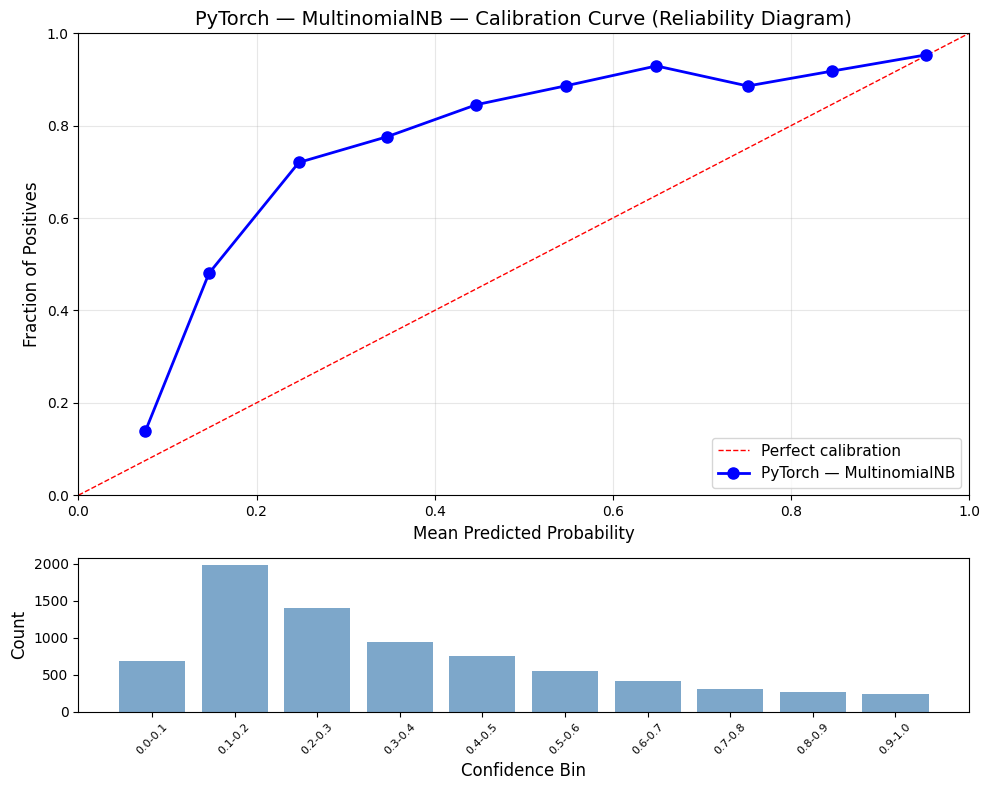

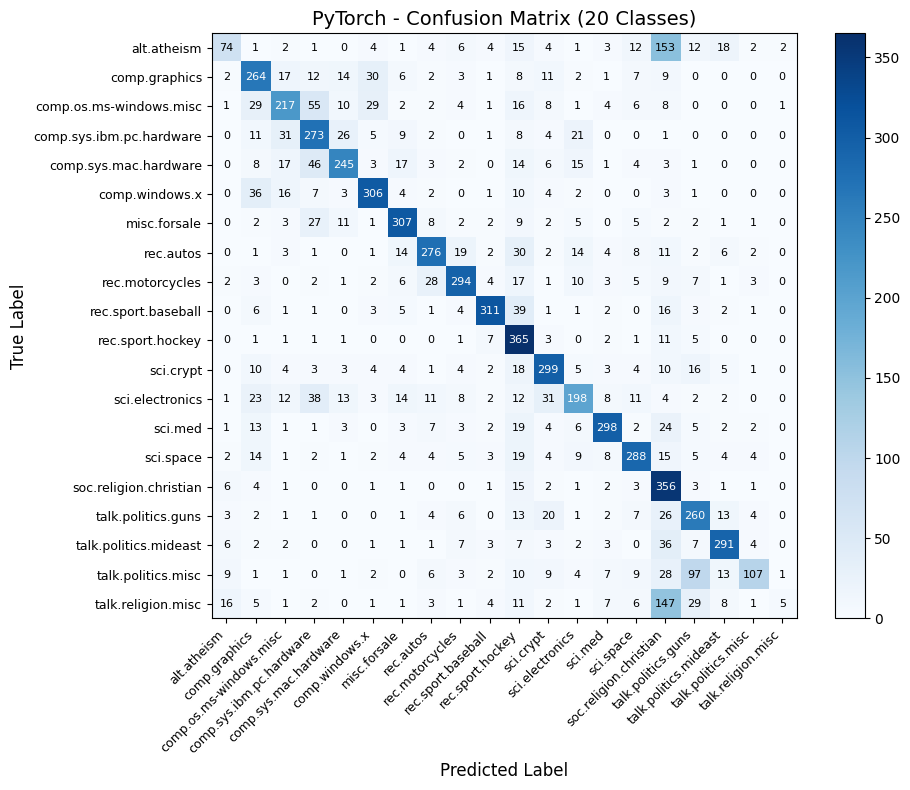

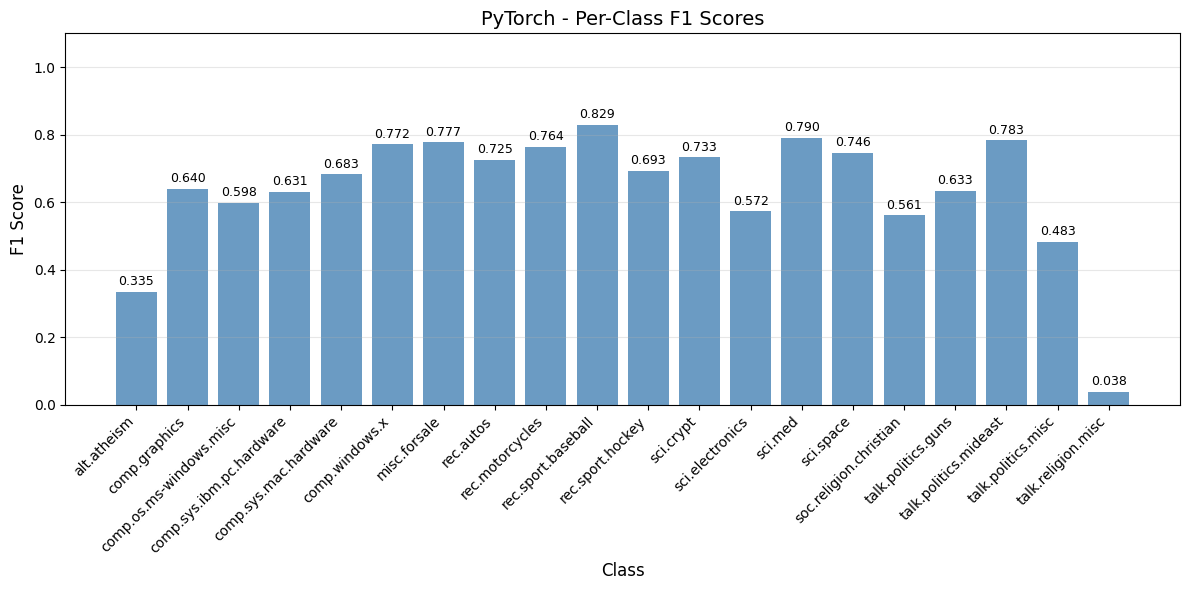

MultinomialNB evaluation complete.
Key: 66.8% accuracy, ECE=0.3229


In [6]:
# Step 5: MultinomialNB visualizations
"""
Same three plots as other frameworks: calibration curve, confusion matrix, per-class F1.
Convert GPU tensors to numpy for plotting utilities.
"""
class_names = meta_t.get('class_names', [f'Class {i}' for i in range(20)])

plot_calibration_curve(y_test_t, test_proba_t.cpu().numpy(),
                       f'{FRAMEWORK} — MultinomialNB', n_bins=10,
                       save_path='results/multinomial_calibration.png')

plot_confusion_matrix_multiclass(y_test_t, test_pred_t.cpu().numpy(), class_names, FRAMEWORK,
                                  save_path='results/multinomial_confusion_matrix.png')

plot_per_class_f1(y_test_t, test_pred_t.cpu().numpy(), class_names, FRAMEWORK,
                  save_path='results/multinomial_per_class_f1.png')

print(f"MultinomialNB evaluation complete.")
print(f"Key: {test_metrics_t['accuracy']:.1%} accuracy, ECE={test_metrics_t['ece']:.4f}")